## **10. Unsupervised ML**

### **10-1. 차원 축소**
- 계산 비용 절감, 데이터 노이즈 감소, 데이터셋 다루기 쉬움, 결과 이해 쉬워짐 등
- 3가지 방법: Feature selection / Feature extraction / Clustering
  - Fature extraction: 주성분/요인/독립성분/다차원 척도법 등

#### 주성분 분석 (PCA)
- 독립변수들의 정규분포 가정 / 척도 상이하지 않도록 표준화 변수 변환 필요
- 주성분: 독립변수에 가중치를 저용한 선형결합. 추가 성분은 다른 성분과 수직 관계  
  고유벡터(Eigenvector): 주성분 변형시 사용되는 가중치로써 부하(loadings)라고도 함  
  고유값(Eigenvalue): 고유벡터 방향의 분산 크기. 클수록 해당 주성분이 데이터 다양성을 더 잘 설명
- 장점: 고차원 데이터 손실 최소화하며 차원 축소  
  단점: 그래프 해석 어려움 (주성분은 여러 특성의 조합), 비선형 구조 반영 불가

In [1]:
# 데이터 불러오기
from pandas import DataFrame
from sklearn.datasets import load_wine
load = load_wine()
X = DataFrame(load['data'], columns = load['feature_names'])
y = load['target']
print("feature {}개, data {}개".format(X.shape[1], X.shape[0]))

# 데이터 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_X = DataFrame(ss.fit_transform(X), columns=X.columns)

feature 13개, data 178개


In [2]:
# PCA 적합
from sklearn.decomposition import PCA
model = PCA(n_components=X.shape[1], svd_solver='auto') #전체 feature 수를 입력
model.fit(scaled_X)

# 고유값 요약
e_value = DataFrame({'고유값':model.explained_variance_, '기여율':model.explained_variance_ratio_}, index=['comp%s'%i for i in range(1,X.shape[1]+1)])
e_value['누적기여율'] = e_value['기여율'].cumsum()
print("고유값 요약:\n", e_value, "\n")

고유값 요약:
              고유값       기여율     누적기여율
comp1   4.732437  0.361988  0.361988
comp2   2.511081  0.192075  0.554063
comp3   1.454242  0.111236  0.665300
comp4   0.924166  0.070690  0.735990
comp5   0.858049  0.065633  0.801623
comp6   0.645282  0.049358  0.850981
comp7   0.554141  0.042387  0.893368
comp8   0.350466  0.026807  0.920175
comp9   0.290512  0.022222  0.942397
comp10  0.252320  0.019300  0.961697
comp11  0.227064  0.017368  0.979066
comp12  0.169724  0.012982  0.992048
comp13  0.103962  0.007952  1.000000 



C:\Users\sunwa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sunwa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sunwa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


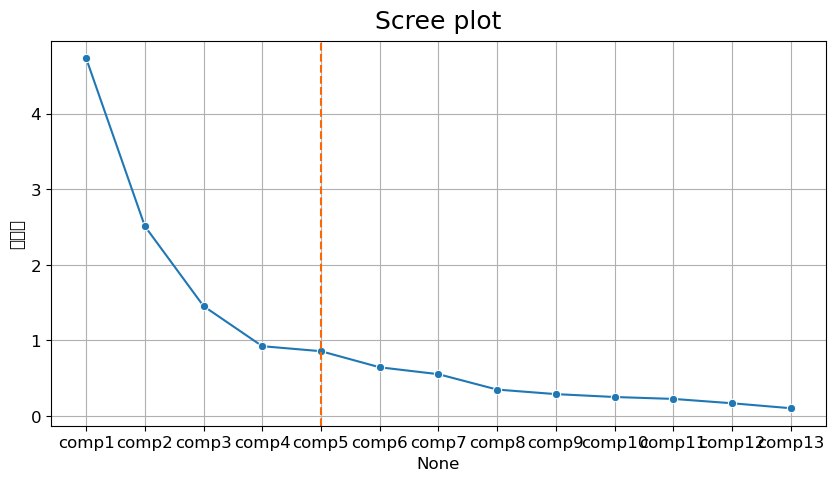

In [3]:
# 고유값 scree plot: elbow 지점의 성분까지 주성분으로 하여 차원 축소할 수 있다.
## comp1~5가 전체 분산의 80%를 설명하고 있으므로 n_components를 5로 하여 fit_transform하고 차원 축소된 데이터를 얻을 수 있다.
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["font.size"] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(x=e_value.index, y='고유값', marker="o", data=e_value, ax=ax)
ax.grid()
ax.set_title('Scree plot', fontsize=18, pad=9)
for i, v in enumerate(e_value['누적기여율']):
    if v > 0.8:
        ax.axvline(e_value.index[i], ls='--', color='#ff6600')
        best_dim = i+1 # 누적기여율이 처음으로 0.8 이상이 되도록 하는 차원 수
        break
plt.show()

In [18]:
# 차원 축소하여 PCA 적합
model = PCA(n_components=best_dim, svd_solver='auto') # best_dim 입력
model.fit(scaled_X)
PCA_result = model.fit_transform(scaled_X) # 차원 축소 결과

# 고유벡터 요약
e_vector = DataFrame(model.components_, index=['comp%s'%i for i in range(1,best_dim+1)], columns=scaled_X.columns)
print("고유벡터 요약:\n", e_vector.iloc[:, :5], "\n") #5개 feature까지만 조회

고유벡터 요약:
         alcohol  malic_acid       ash  alcalinity_of_ash  magnesium
comp1  0.144329   -0.245188 -0.002051          -0.239320   0.141992
comp2  0.483652    0.224931  0.316069          -0.010591   0.299634
comp3 -0.207383    0.089013  0.626224           0.612080   0.130757
comp4 -0.017856    0.536890 -0.214176           0.060859  -0.351797
comp5 -0.265664    0.035214 -0.143025           0.066103   0.727049 



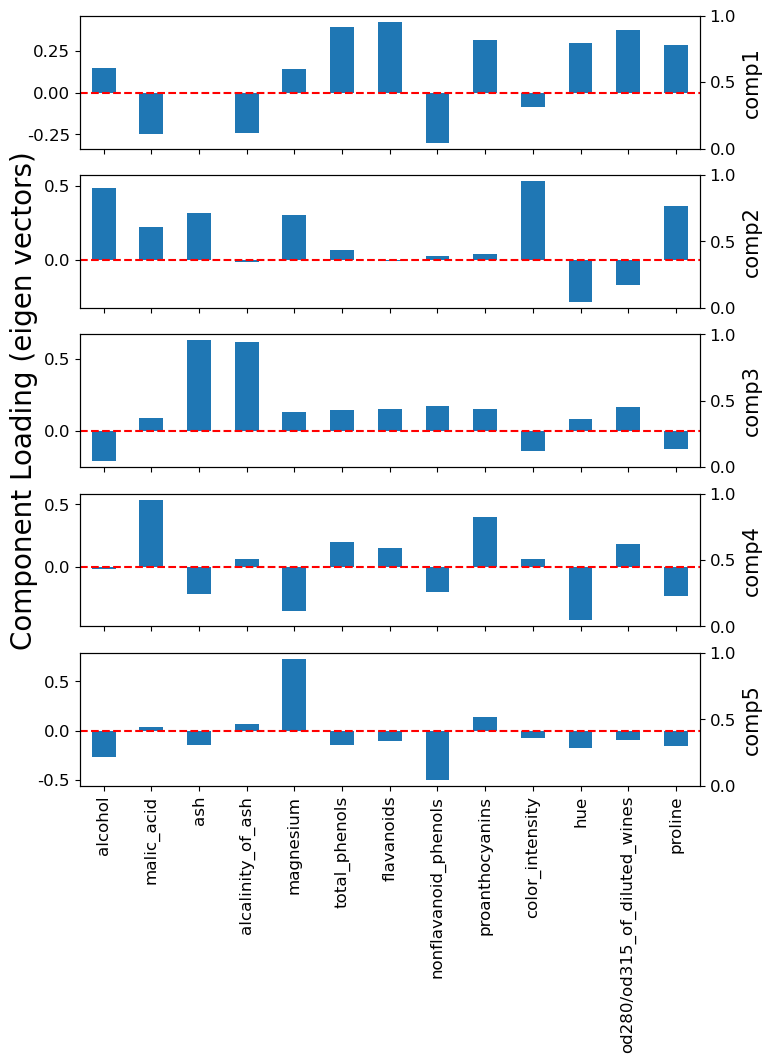

In [9]:
# 고유벡터 plot: feature의 고유벡터값이 클수록 해당 주성분에 영향을 많이 주는 feature임
fig, axes = plt.subplots(best_dim, 1, figsize=(8,10))
for i, ax in enumerate(axes):
    e_vector.iloc[i, :].plot.bar(ax=ax, rot=90)
    ax.set_xticks(list(range(len(e_vector.columns))))
    ax.set_xticklabels([" " for i in range(len(e_vector.columns))])
    twin_ax = ax.twinx()
    twin_ax.set_ylabel(e_vector.index[i], fontsize=15)
    ax.axhline(y=0, linestyle='dashed', color='red')
ax.set_xticks(list(range(len(e_vector.columns))))
ax.set_xticklabels(list(e_vector.columns))
axes[round(best_dim/2)].set_ylabel("Component Loading (eigen vectors)", fontsize=20)
plt.show()

In [13]:
!pip install pca

[scatterd] >INFO> Create scatterplot


[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [13] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


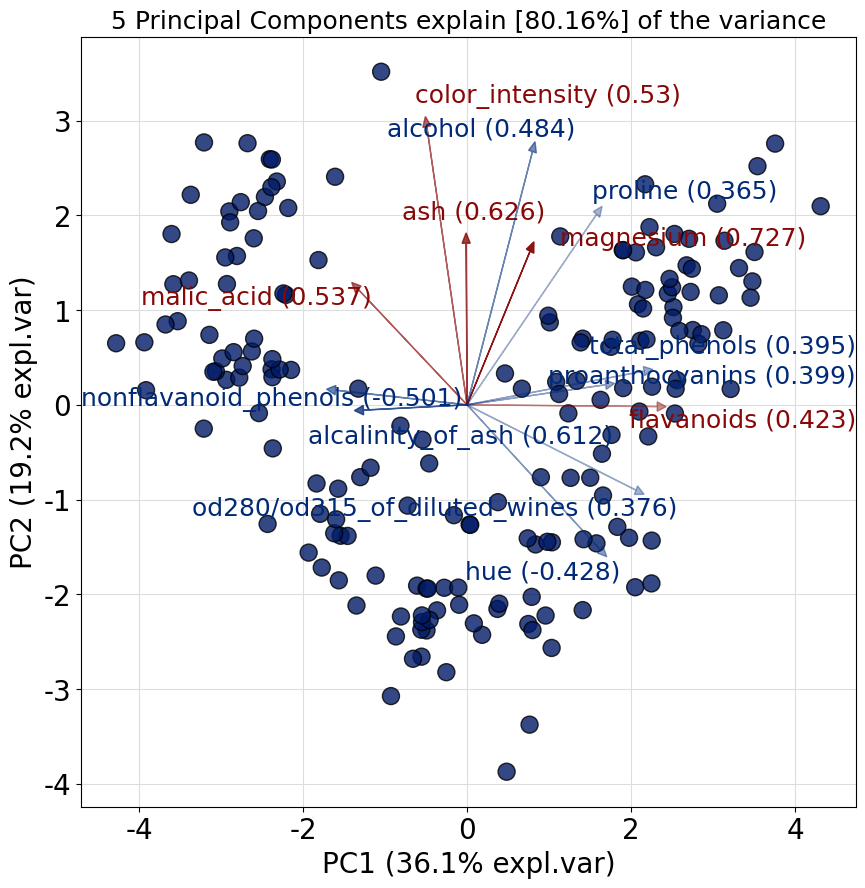

In [12]:
# biplot을 통한 PCA 결과 해석:
#1. 각 PC축에 가깝게 평행을 이루는 변수가 해당 PC에 영향을 가장 많이 주는 변수이다.
#2. 각 빨간선의 길이는 원변수의 분산을 표현, 길이가 길수록 분산이 크다.
#3. 각 빨간선이 가까울수록 서로 상관관계가 있다.

from pca import pca
model = pca(n_components=5)
model.fit_transform(scaled_X)
fig, ax = model.biplot(n_feat=scaled_X.shape[1], legend=False, figsize=(10, 10))
plt.show()
plt.close()

#### 요인 분석 (Factor Analysis)
- 잠재변수에 대한 연결된 분산을 찾고, 여기에 오차를 추가한 인자들의 선형 결합
- 탐색적 vs. 확인 요인 분석: 변수-요인 관계에 대한 가설 여부에 따라
- 변수 축소, 불필요 변수 제거, 변수 특성 파악, 요인점수 이용한 변수 생성 등

In [19]:
# 데이터 불러오기
from pandas import DataFrame
from sklearn.datasets import load_wine
load = load_wine()
X = DataFrame(load['data'], columns = load['feature_names'])
y = load['target']
print("feature {}개, data {}개".format(X.shape[1], X.shape[0]))

# 데이터 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_X = DataFrame(ss.fit_transform(X), columns=X.columns)

feature 13개, data 178개


In [29]:
# FA 적합
from sklearn.decomposition import FactorAnalysis
best_dim = 5 # 잠재변수 5개
model = FactorAnalysis(n_components=best_dim)
model.fit(scaled_X)
FA_result = model.transform(scaled_X)

# 각 잠재요인의 feature별 최대 분산
max_var = DataFrame(model.components_, index=['latent%s'%i for i in range(1,best_dim+1)], columns=load['feature_names'])
print("잠재요인 요약:\n", max_var.iloc[:, :5], "\n") #5개 feature까지만 조회

잠재요인 요약:
           alcohol  malic_acid       ash  alcalinity_of_ash  magnesium
latent1  0.299731   -0.424489  0.143386          -0.387691   0.275096
latent2 -0.423886   -0.283977 -0.866066          -0.364116  -0.409356
latent3 -0.576480   -0.039512  0.368996           0.537425  -0.228729
latent4 -0.117865   -0.148264 -0.013634          -0.073661   0.668697
latent5 -0.194167    0.157465 -0.071648           0.239827   0.209583 



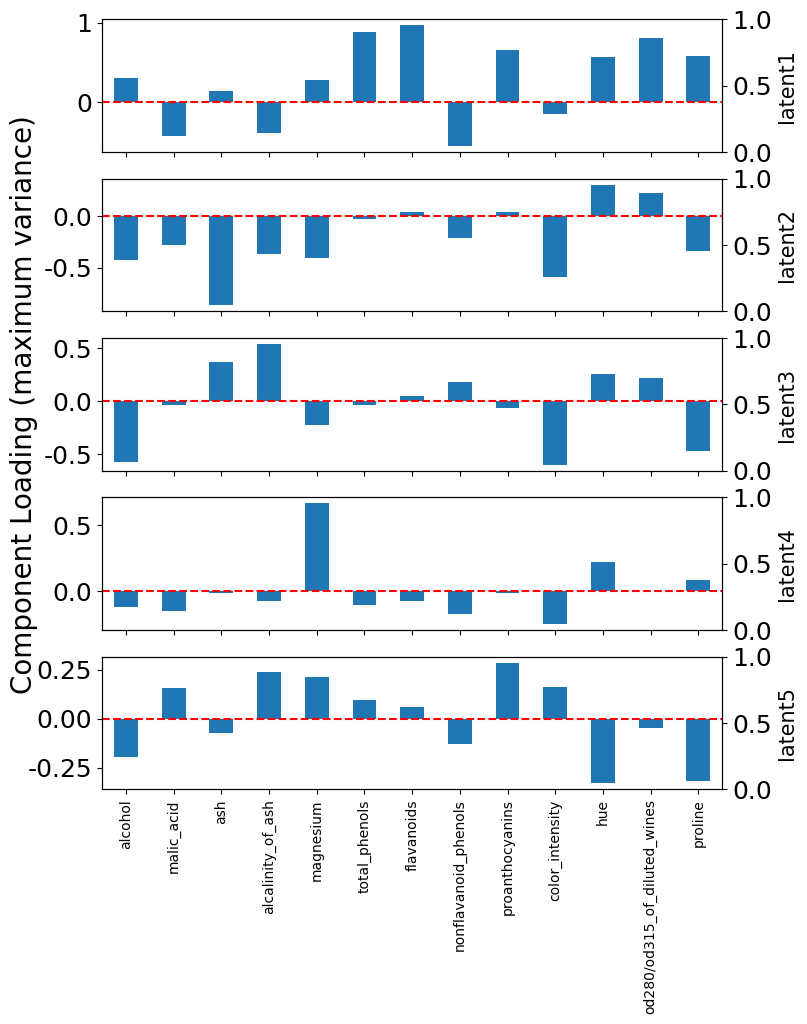

In [23]:
# 각 잠재요인의 feature별 최대 분산 시각화
fig, axes = plt.subplots(best_dim, 1, figsize=(8,10))
for i, ax in enumerate(axes):
    max_var.iloc[i, :].plot.bar(ax=ax, rot=90)
    ax.set_xticks(list(range(len(max_var.columns))))
    ax.set_xticklabels([" " for i in range(len(max_var.columns))])
    twin_ax = ax.twinx()
    twin_ax.set_ylabel(max_var.index[i], fontsize=15)
    ax.axhline(y=0, linestyle='dashed', color='red')
ax.set_xticks(list(range(len(max_var.columns))))
ax.set_xticklabels(list(max_var.columns),fontsize=10)
axes[round(best_dim/2)].set_ylabel("Component Loading (maximum variance)", fontsize=20)
plt.show()

#### 독립성분 분석 (ICA)
- 다변량 신호를 최대한 독립적인 하부 성분으로 분리
- 중첩된 신호 분리에 사용 (ex. 여러 사람 중 특정 인물의 목소리 추출)
- ICA모델에는 잡음항이 포함되어 있지 않아 백색화(whitening) 필요

In [1]:
# 데이터 불러오기
from pandas import DataFrame
from sklearn.datasets import load_wine
load = load_wine()
X = DataFrame(load['data'], columns = load['feature_names'])
y = load['target']
print("feature {}개, data {}개".format(X.shape[1], X.shape[0]))

# 데이터 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_X = DataFrame(ss.fit_transform(X), columns=X.columns)

feature 13개, data 178개


In [5]:
# ICA 적합
from sklearn.decomposition import FastICA
best_dim = 5
model = FastICA(n_components=best_dim, algorithm='parallel', whiten='unit-variance', fun='logcosh')
model.fit(scaled_X)
ICA_result = model.transform(scaled_X)

# 독립 소스를 얻기 위해 데이터에 적용할 선형 연산자
ind_comp = DataFrame(model.components_, index=['ind comp%s'%i for i in range(1,best_dim+1)], columns=load['feature_names'])
print("독립 성분 요약:\n", ind_comp.iloc[:, :5], "\n") #5개 feature까지만 조회

독립 성분 요약:
             alcohol  malic_acid       ash  alcalinity_of_ash  magnesium
ind comp1 -0.353632   -0.157038 -0.039461           0.145830  -0.088312
ind comp2 -0.085572    0.107275  0.555509           0.488778   0.165676
ind comp3 -0.060833    0.131516 -0.009690           0.105375  -0.050015
ind comp4  0.109676   -0.540280  0.254558          -0.087963   0.175547
ind comp5 -0.250611   -0.090931 -0.100228           0.037833   0.858894 



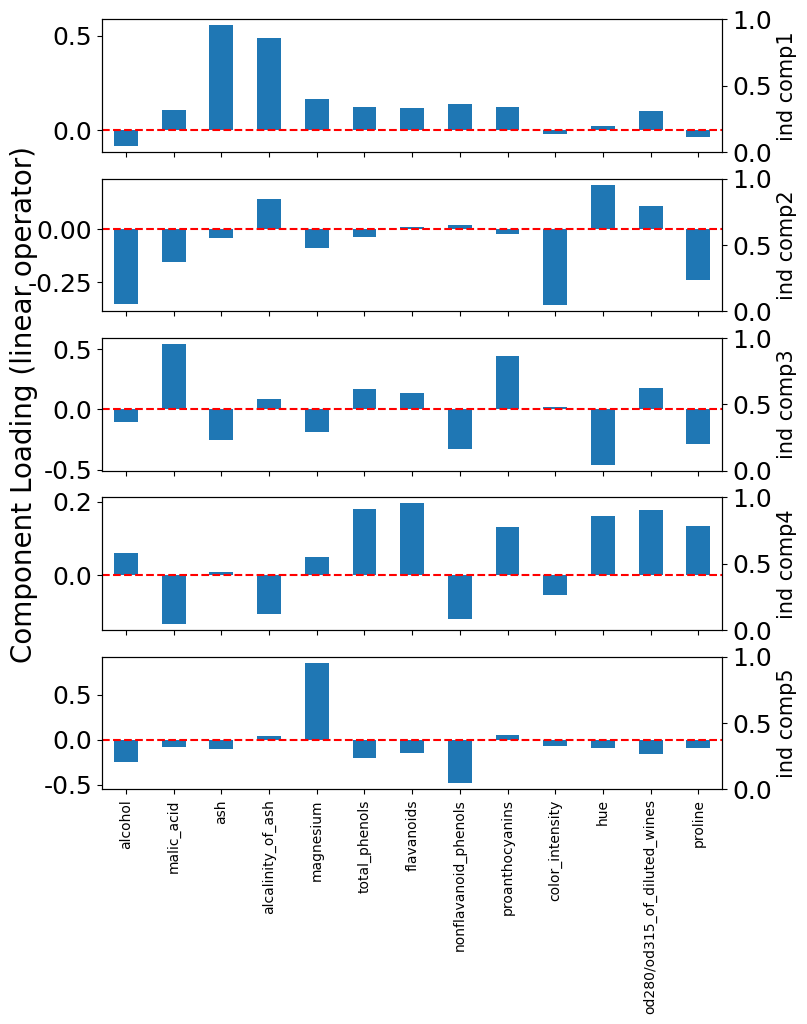

In [34]:
# 각 잠재요인의 feature별 최대 분산 시각화
fig, axes = plt.subplots(best_dim, 1, figsize=(8,10))
for i, ax in enumerate(axes):
    ind_comp.iloc[i, :].plot.bar(ax=ax, rot=90)
    ax.set_xticks(list(range(len(ind_comp.columns))))
    ax.set_xticklabels([" " for i in range(len(ind_comp.columns))])
    twin_ax = ax.twinx()
    twin_ax.set_ylabel(ind_comp.index[i], fontsize=15)
    ax.axhline(y=0, linestyle='dashed', color='red')
ax.set_xticks(list(range(len(ind_comp.columns))))
ax.set_xticklabels(list(ind_comp.columns),fontsize=10)
axes[round(best_dim/2)].set_ylabel("Component Loading (linear operator)", fontsize=20)
plt.show()

#### 음수 미포함 행렬 분해 (NMF)

In [35]:
# 데이터 불러오기
from pandas import DataFrame
from sklearn.datasets import load_wine

load = load_wine()
X = DataFrame(load['data'], columns = load['feature_names'])
y = load['target']
print("feature {}개, data {}개".format(X.shape[1], X.shape[0]))

# 데이터 표준화 (0~1사이에 데이터가 오도록 MinMaxScaler를 사용)
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
scaled_X = DataFrame(mm.fit_transform(X), columns=X.columns)

feature 13개, data 178개


In [36]:
# NMF 적합
from sklearn.decomposition import NMF
best_dim = 5
model = NMF(n_components=best_dim, init='random', max_iter=2000)
model.fit(scaled_X)
NMF_result = model.transform(scaled_X) # W에 해당

# H에 해당 (Factorization matrix)
NMF_comp = DataFrame(model.components_, index=['NMF comp%s'%i for i in range(1,best_dim+1)], columns=load['feature_names'])
print("NMF 성분 요약:\n", NMF_comp.iloc[:, :5], "\n") #5개 feature까지만 조회

NMF 성분 요약:
             alcohol  malic_acid       ash  alcalinity_of_ash  magnesium
NMF comp1  0.445851    0.010721  0.207464           0.000000   0.200757
NMF comp2  0.000000    0.009586  0.288123           0.368975   0.179049
NMF comp3  0.379652    0.190582  0.446286           0.441960   0.330482
NMF comp4  0.152086    0.000000  0.330301           0.304828   0.000000
NMF comp5  0.413473    1.115580  0.138718           0.136272   0.000000 



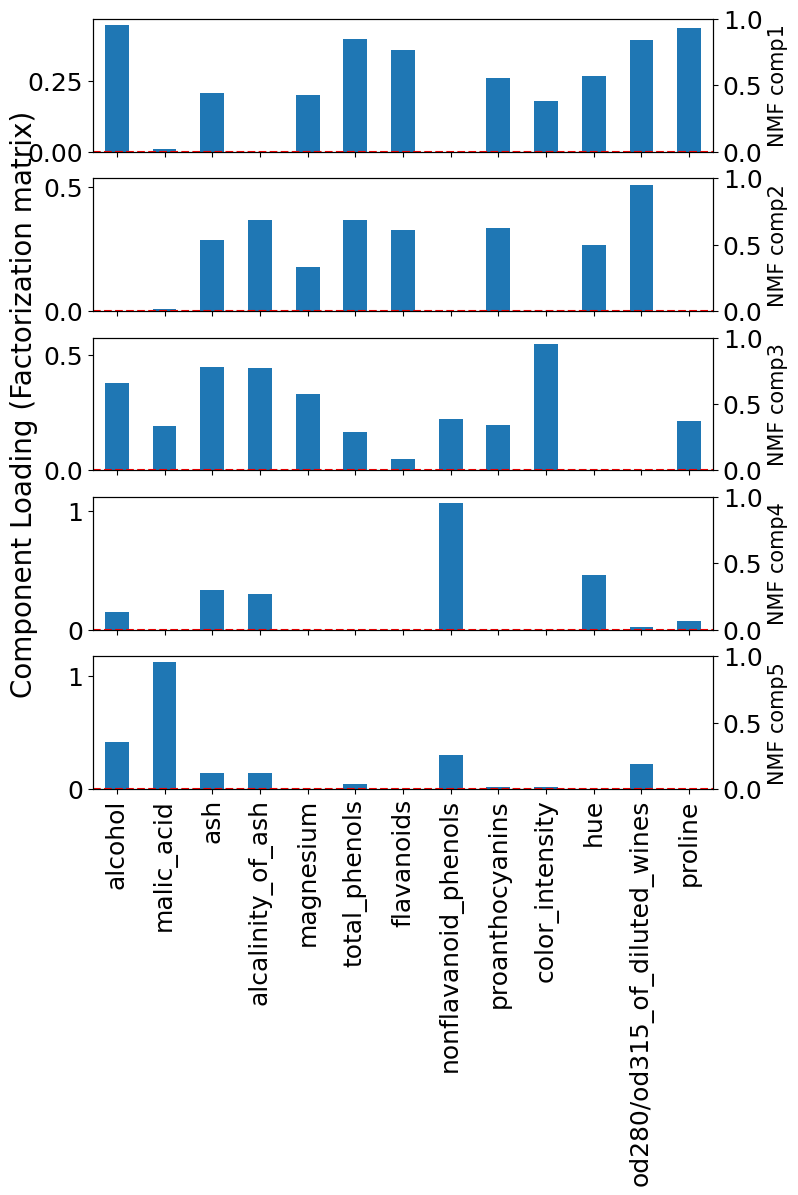

In [37]:
# 각 성분의 feature별 시각화
fig, axes = plt.subplots(best_dim, 1, figsize=(8,10))
for i, ax in enumerate(axes):
    NMF_comp.iloc[i, :].plot.bar(ax=ax, rot=90)
    ax.set_xticks(list(range(len(NMF_comp.columns))))
    ax.set_xticklabels([" " for i in range(len(NMF_comp.columns))])
    twin_ax = ax.twinx()
    twin_ax.set_ylabel(NMF_comp.index[i], fontsize=15)
    ax.axhline(y=0, linestyle='dashed', color='red')
ax.set_xticks(list(range(len(NMF_comp.columns))))
ax.set_xticklabels(list(NMF_comp.columns))
axes[round(best_dim/2)].set_ylabel("Component Loading (Factorization matrix)", fontsize=20)
plt.show()

#### 다차원 척도법 (MDS)
- 반복 알고리즘을 통해 stress값을 최소로하는 최종 모형 선택
  - stress: 실제 데이터 간의 거리와 MDS로 추정된 거리 간의 차이 (일종의 오차)
  - 0에 가까울수록 적합도 높음. 0.1이하 Good, 0.15 이상 Bad
- scree plot을 통해 차원 수를 늘려가면서 elbow 방법으로 최저 차원수 결정
- 계량적 MDS: 구간/비율 척도, 유클리드 거리 행렬 계산, 비유사성 공간상 표현  
  비계량적 MDS: 서열척도 (파라미터 metric=False로 설정)

In [6]:
# 데이터 불러오기
from pandas import DataFrame
from sklearn.datasets import load_wine
load = load_wine()
X = DataFrame(load['data'], columns = load['feature_names'])
y = load['target']
print("feature {}개, data {}개".format(X.shape[1], X.shape[0]))

# 데이터 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_X = DataFrame(ss.fit_transform(X), columns=X.columns)

feature 13개, data 178개


차원 수 2일 때, stress 0.2301572646914574
차원 수 3일 때, stress 0.14421638408180104
차원 수 4일 때, stress 0.10153475198496567
차원 수 5일 때, stress 0.07167081747123692
차원 수 6일 때, stress 0.05262312447954534


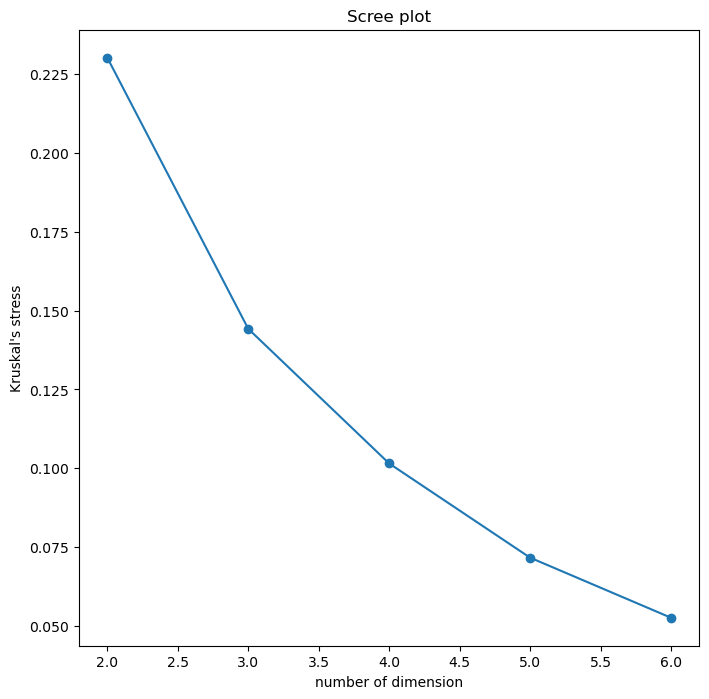

In [10]:
# 데이터 간의 실제 거리 계산하기
from sklearn.metrics import pairwise_distances
distances = pairwise_distances(scaled_X) # metric='euclidean'

# 최적의 차원 수 찾기
Slist = []
from sklearn.manifold import MDS
import numpy as np
for i in range(2,7): 
    mds = MDS(n_components=i, metric=True, random_state=0)
    mds.fit(scaled_X)
    # reduced_d = pairwise_distances(mds.embedding_) # 차원 축소된 데이터 간의 거리
    # distances = mds.dissimilarity_matrix_ # 데이터 간 실제 거리
    sklearn_stress = mds.stress_ # ~ 0.5*np.sum((distances-reduced_d)**2)
    kruskal_stress = np.sqrt(sklearn_stress / (0.5 * np.sum(distances**2))) #stress-1
    Slist.append(kruskal_stress)
    print("차원 수 {}일 때, stress {}".format(i, kruskal_stress))

# scree plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (8,8)
plt.title("Scree plot")
plt.plot(list(range(2,7)), Slist, marker='o')
plt.xlabel("number of dimension")
plt.ylabel("Kruskal's stress")
plt.show()

In [43]:
# MDS 적합
best_dim = 5
model = MDS(n_components=best_dim, metric=True)
MDS_result = DataFrame(model.fit_transform(scaled_X)) # model.embedding_과 동일
reduced_d = pairwise_distances(model.embedding_)

print( "raw stress: {:.3f}(~ {:.3f})".format(model.stress_, 0.5*np.sum((distances-reduced_d)**2)) )
print("kruskal stress: {:.3f}(~ {:.3f})".format(
    np.sqrt(model.stress_ / (0.5 * np.sum(distances**2))), 
    np.sqrt(np.sum((distances-reduced_d)**2) / np.sum(distances**2))))

raw stress: 2208.939(~ 2208.066)
kruskal stress: 0.073(~ 0.073)


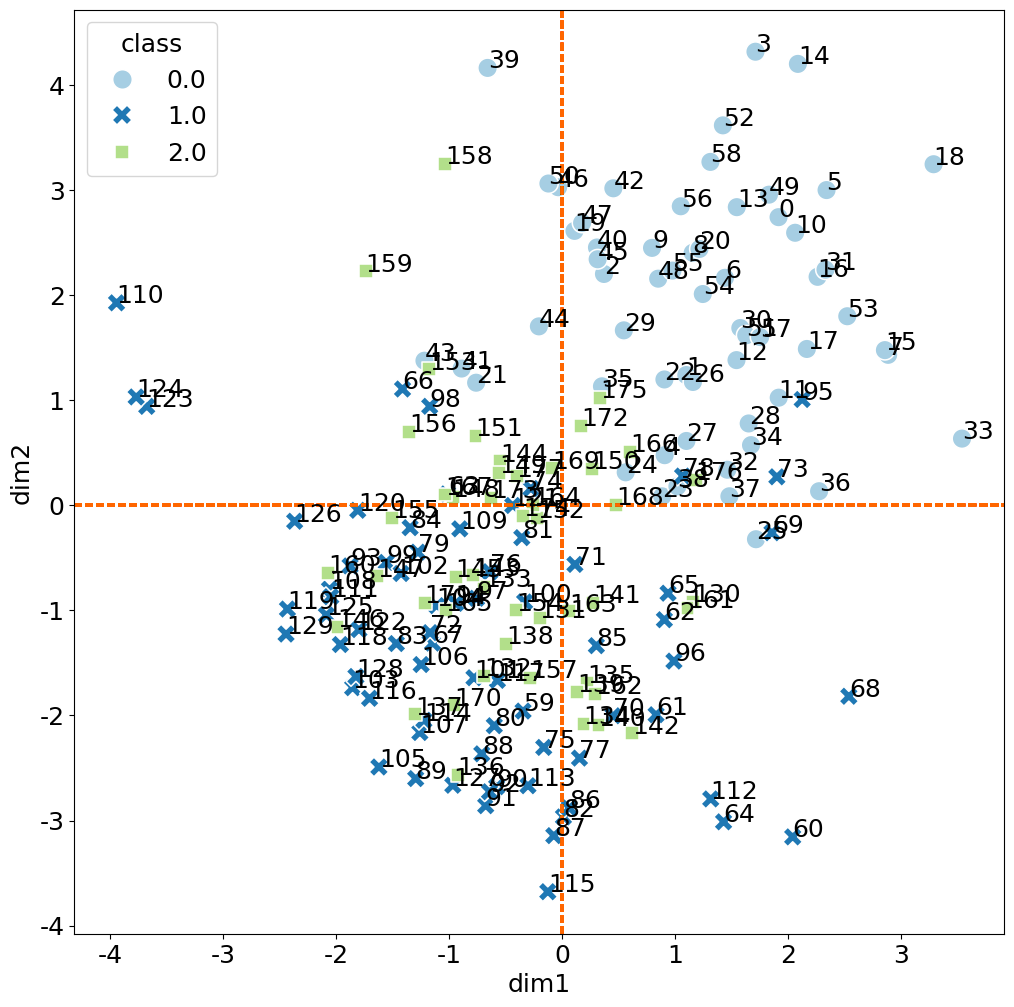

In [52]:
import seaborn as sns
from matplotlib import pyplot as plt
reduced_data = DataFrame(np.c_[MDS_result.values, y], columns=['dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'class'])
plt.rcParams['figure.figsize'] = (12, 12)
sns.scatterplot(x='dim1', y='dim2', data=reduced_data, style='class', style_order=[0,1,2], hue='class', palette='Paired', s=200)
for i, name in enumerate(MDS_result.index):
    plt.text(reduced_data.loc[i, 'dim1'], reduced_data.loc[i, 'dim2'], name)
    plt.axhline(0, 0, ls='--', color='#ff6600')
    plt.axvline(0, 0, ls='--', color='#ff6600')
plt.show()

## MDS에 의해 축소된 feature로 그린 산점도로부터 wine 종류 간의 비유사도를 확인할 수 있다.

#### 원본 데이터와 차원 축소 데이터로 적합한 모델 성능 비교

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
data_list = [scaled_X, PCA_result, FA_result, ICA_result, NMF_result, MDS_result]
title_list = ['original', 'PCA', 'FA', 'ICA', 'NMF', 'MDS']
y = load['target']

for X, title in zip(data_list, title_list):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
    lr= LinearRegression().fit(X_train, y_train)
    trainS, testS = lr.score(X_train, y_train), lr.score(X_test, y_test)
    print("{} data: ".format(title))
    print("train score: {:.3f}, test score: {:.3f}\n".format(trainS, testS))

original data: 
train score: 0.890, test score: 0.915

PCA data: 
train score: 0.827, test score: 0.828

FA data: 
train score: 0.877, test score: 0.880

ICA data: 
train score: 0.827, test score: 0.828

NMF data: 
train score: 0.863, test score: 0.893

MDS data: 
train score: 0.820, test score: 0.830



### **10-2. 군집 분석**
- **전처리** 중요: 표준화 (거리기반 모델링), 이상치 제거나 조정
- 모든 설명 변수를 고려하기 때문에, 중요하지 않은 변수가 많을수록 정확도 낮음

#### 10-2-1. 계층적 군집 분석
- 장점: 특이점 or 비정상 그룹 발견 쉬움, 클러스터 해석 수월 / 단점: 대규모 적용 X
- **덴드로그램** 시각화 가능

In [26]:
# 합병형 군집분석
from pandas import DataFrame
import numpy as np
from sklearn.datasets import load_iris
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
# 데이터 불러오기
load = load_iris()
X = load['data']
y = load['target']
columns = list(map(lambda x: x.replace("(cm)", "").replace(" ", "_"), load['feature_names']))

# 데이터 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df = DataFrame(ss.fit_transform(X), columns=columns)

# 군집화 상세내역 매트릭스
Z = linkage(df, method='complete')
print(Z[:3, :].round()) # 일부만 확인
# linkage의 method는 single, complete, average, weighted, centroid, median, ward로 입력할 수 있다. 
# 위의 Z는 4열로 된 matrix인데, 0열과 1열은 인덱스, 2열은 0-1열 인덱스 쌍의 거리, 3열은 클러스터 내 관찰값의 개수를 반환한다. 
# 0, 1열에서 인덱스값이 관찰값 이상으로 296, 297까지 나오는 이유는 그 상위에 병합된 클러스터들이 관찰값에 이어서 새로운 인덱스로 생성되기 때문이다.

[[101. 142.   0.   2.]
 [  7.  39.   0.   2.]
 [ 10.  48.   0.   2.]]


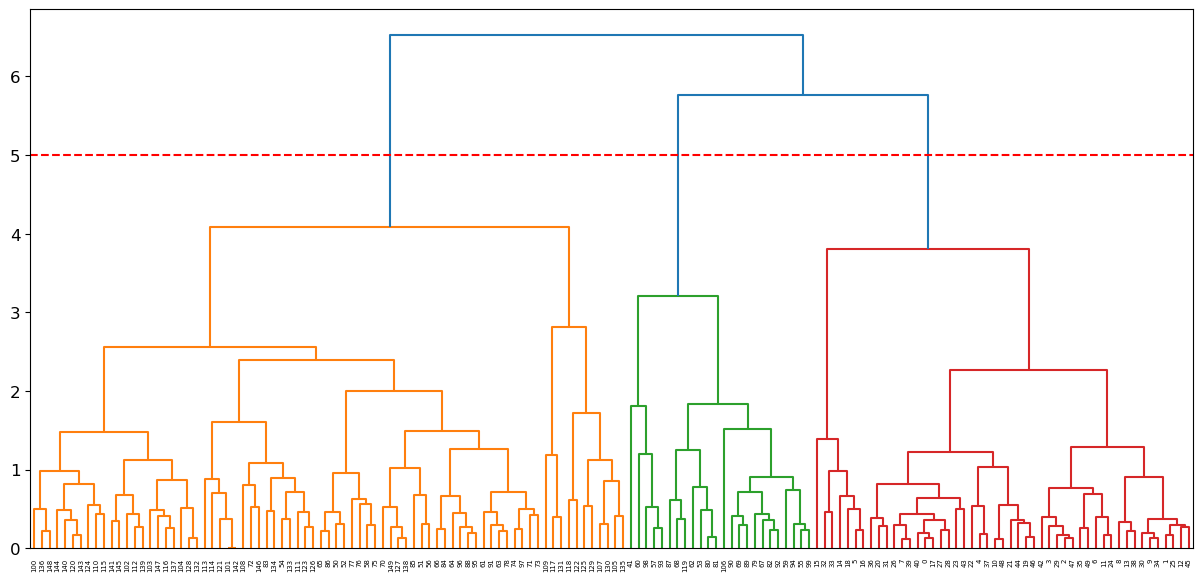

In [27]:
# 군집화 결과 시각화
distance_setting = 5
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
dendrogram(Z, labels=list(df.index), color_threshold=distance_setting) 
# color_threshold 값을 설정하면 해당 거리값을 기준으로 색상이 다른 군집들을 나눠줌
plt.xticks(rotation=90)
ax.axhline(y=distance_setting, linestyle='dashed', color='red')
plt.show()

In [28]:
# n_cluster로 정한 군집의 개수를 기반으로 각 데이터의 군집을 반환
n_cluster = 3
Hclustering_result = cut_tree(Z, n_cluster).flatten()
print(Hclustering_result)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 2 1 2 2 2 2 1 1 1 2 2 2 2
 2 2 2 2 2 1 1 1 1 2 2 2 2 1 2 1 1 2 1 1 1 2 2 2 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [29]:
# 타당성 평가: clustering한 군집번호와 target의 군집번호가 꼭 일치할 필요는 없고, 유사한 데이터들끼리 군집화만 잘 되어 있으면 된다.
from sklearn.metrics import silhouette_score, completeness_score
print("실루엣 계수: %.3f" %silhouette_score(df, Hclustering_result))
print("completeness_score: %.3f" %completeness_score(y, Hclustering_result))

# 실루엣 계수: 클러스터 내부의 응집도(cohesion)와 클러스터 간 분리도(separation)를 종합적으로 평가하는 지표
# 레이블이 없는 데이터에 대한 클러스터링 품질을 평가할 때 주로 사용
# 범위: −1 (최악) ~ +1 (최적)

# 완전성 점수: 실제 레이블(ground truth)을 기준으로 클러스터링이 동일한 클래스의 데이터를 하나의 클러스터로 묶은 정도를 평가
# 범위: 0 (최악) ~ 1 (최적)

실루엣 계수: 0.450
completeness_score: 0.685


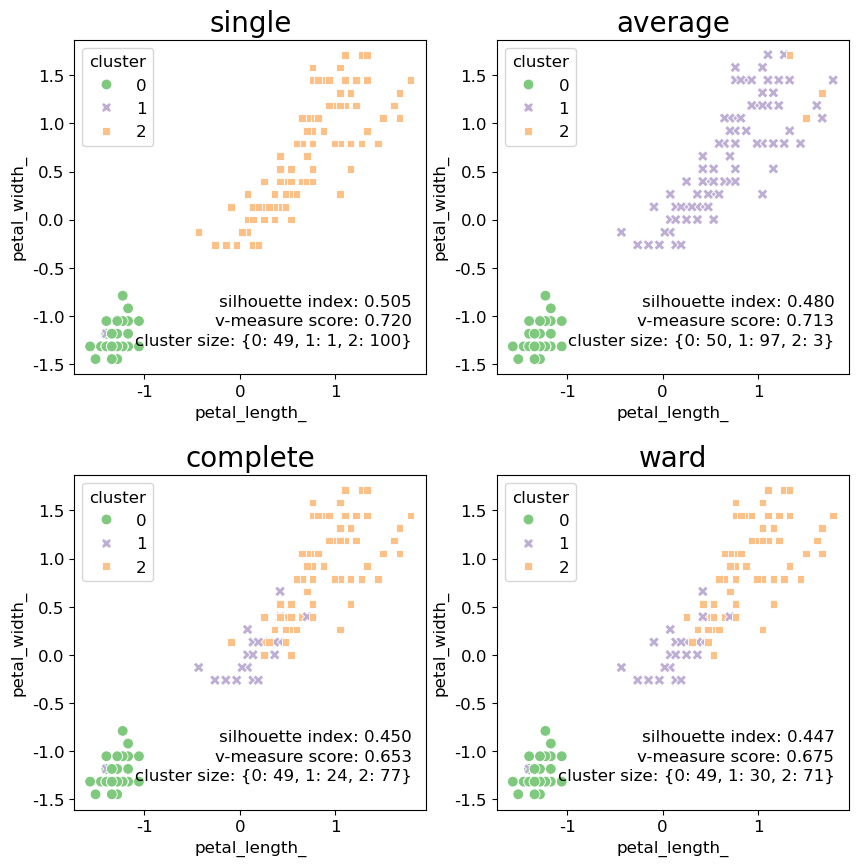

In [30]:
# 비유사도 측정 지표 별 군집 결과 비교
from pandas import merge
from collections import Counter
import seaborn as sns
from sklearn.metrics import silhouette_score, v_measure_score
fig, axes = plt.subplots(2,2, figsize=(10,10))
plt.rcParams["font.size"] = 12
plt.rcParams['axes.unicode_minus'] = False
plt.subplots_adjust(hspace=0.3)

methods = ['single', 'average', 'complete', 'ward']
for ax, method in zip(axes.ravel(), methods):
    Z = linkage(df, method=method)
    cluster = DataFrame({'cluster': cut_tree(Z,3).flatten()})
    ddf = merge(df, cluster, left_index=True, right_index=True)
    sns.scatterplot(x='petal_length_', y='petal_width_', data=ddf, hue='cluster', style='cluster', s=60, ax=ax, palette='Accent')
    ax.text(1.8, -0.9, "silhouette index: %.3f" %silhouette_score(df, ddf['cluster']), horizontalalignment='right')
    ax.text(1.8, -1.1, "v-measure score: %.3f" %v_measure_score(load_iris()['target'], ddf['cluster']), horizontalalignment='right')
    cluster_size = dict(Counter(ddf['cluster']))
    ax.text(1.8, -1.3, "cluster size: {}".format(cluster_size), horizontalalignment='right')
    ax.set_title(method, fontsize=20)
plt.show()
## 평가 점수 자체는 single이 가장 높게 나왔지만 시각화된 군집 고려했을 때 complete과 ward의 군집화 결과가 타당하게 보인다.

#### 10-2-2. 비계층적 군집 분석

#### K-means clustering
- 사용자가 미리 정한 k값과 클러스터 평균 초기값으로 알고리즘 시작
  - 오차제곱합이 평평해지기 시작하는 지점을 k로 지정
- 클러스터 평균과의 오차제곱합 최소 --> 평균 초기값 랜덤 변화시켜 알고리즘 여러 번 반복
- 장점: 이해 쉬움, 구현 쉬움, 비교적 빠름, 대용량 데이터 작동 --> 인기 있는 군집 알고리즘  
  단점: 클러스터 평균 초기값에 따라 다른 결과, 이상치에 민감 (평균 대신 중앙값 사용)  
        클러스터 모양을 가정하고 있기에 활용 범위가 비교적 제한적

In [6]:
# K-means clustering
from pandas import DataFrame
import numpy as np
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

# 데이터 불러오기
load = load_iris()
X = load['data']
y = load['target']
columns = list(map(lambda x: x.replace("(cm)", "").replace(" ", "_"), load['feature_names'])) 

# 데이터 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df = DataFrame(ss.fit_transform(X), columns=columns)

적정한 군집 개수 정하기:


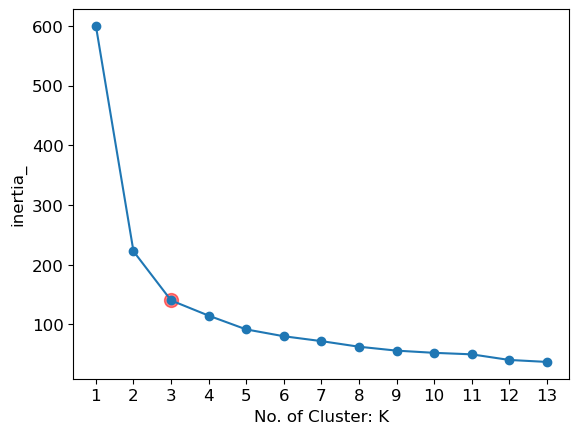

In [8]:
# 적정한 군집 개수 정하기
print("적정한 군집 개수 정하기:")
I = [] # 오차제곱합
for k in range(1,14):
    kmeans=KMeans(n_clusters=k).fit(df)
    I.append(kmeans.inertia_) # 오차제곱합
plt.plot(list(range(1,14)), I, marker="o")

n_cluster = 3
plt.scatter(n_cluster, I[n_cluster-1], color='red', alpha=0.5, s=100)
plt.xticks(list(range(1,14)), list(range(1,14)))
plt.xlabel("No. of Cluster: K")
plt.ylabel("inertia_")
plt.show()

In [11]:
# n_cluster로 정한 군집의 개수를 기반으로 각 데이터의 군집을 반환
model = KMeans(n_clusters=n_cluster, random_state=0)
distances = model.fit_transform(df) # 해당 열 데이터의 각 cluster center와의 거리
kmeans_result = model.labels_ # 각 데이터의 군집 반환
print(kmeans_result)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0
 0 2 2 2 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 2 2 2 2 2 2 0 0 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


In [12]:
# 군집 정보 확인
print("클러스터 구성: ", Counter(model.labels_))
centers = DataFrame(model.cluster_centers_, columns=df.columns, index=["cluster%s" %i for i in range(n_cluster)])
print("클러스터 중심:\n{}".format(centers))

클러스터 구성:  Counter({0: 53, 1: 50, 2: 47})
클러스터 중심:
          sepal_length_  sepal_width_  petal_length_  petal_width_
cluster0      -0.050220     -0.883376       0.347738      0.281527
cluster1      -1.014579      0.853263      -1.304987     -1.254893
cluster2       1.135970      0.088422       0.996155      1.017526


In [13]:
# 타당성 평가: clustering한 군집번호와 target의 군집번호가 꼭 일치할 필요는 없고, 유사한 데이터들끼리 군집화만 잘 되어 있으면 된다.
from sklearn.metrics import silhouette_score, completeness_score
print("실루엣 계수: %.3f" %silhouette_score(df, kmeans_result))
print("completeness_score: %.3f" %completeness_score(y, kmeans_result))

실루엣 계수: 0.460
completeness_score: 0.660


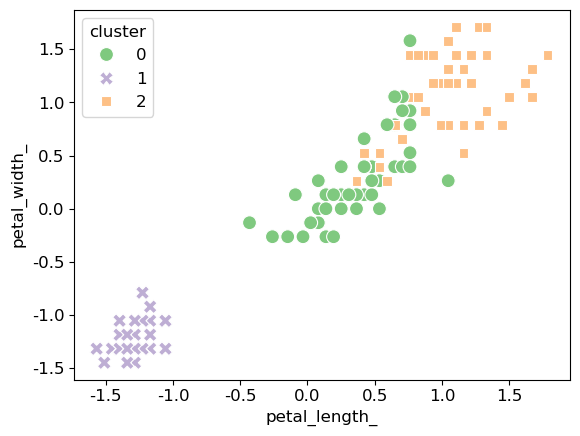

In [14]:
# 군집 결과 시각화
df['cluster'] = kmeans_result
fig, ax = plt.subplots(1,1)
sns.scatterplot(x='petal_length_', y='petal_width_', data=df, hue='cluster', style='cluster', s=100, ax=ax, palette='Accent')
plt.show()

#### DBSCAN (Density-Based)
- 3가지 종류: 핵심 / 경계 (핵심에서 eps 거리 안 위치) / 잡음 데이터
- 파라미터 eps와 min_samples로 클러스터 개수와 최소 크기 제어
- 장점: 비선형과 같은 복잡한 형상 찾기 가능, 노이즈 데이터 구분 가능  
  단점: 밀도 낮은 데이터를 노이즈로 구분 오류, 다소 느림, 데이터 수 비례 모델링 시간 증가

In [13]:
# DBSCAN
from pandas import DataFrame
import numpy as np
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# 데이터 불러오기
load = load_iris()
X = load['data']
y = load['target']
columns = list(map(lambda x: x.replace("(cm)", "").replace(" ", "_"), load['feature_names'])) 

# 데이터 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df = DataFrame(ss.fit_transform(X), columns=columns)

적정한 eps 정하기:


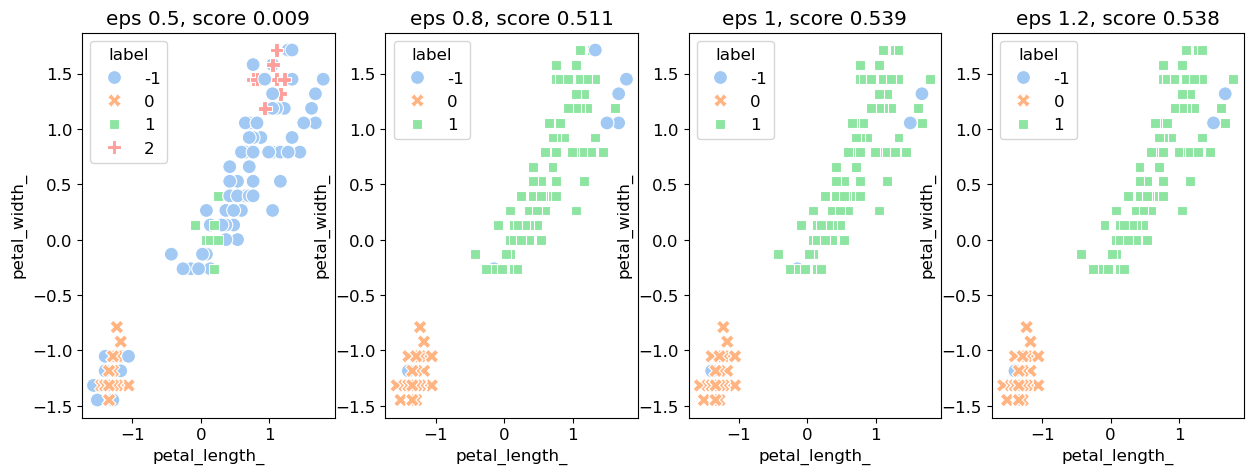

In [21]:
# 적정한 eps 정하기 (min_samples는 10으로 고정함)
# eps를 증가시키면 하나의 클러스터에 더 많은 포인트가 포함된다. 
# 이는 클러스터를 커지게 하지만 여러 클러스터를 하나로 합치게도 만든다. min_samples는 클러스터의 최소 크기를 결정한다.
print("적정한 eps 정하기:")
eps_list =[0.5, 0.8, 1, 1.2] # eps 후보군
fig, axes = plt.subplots(1,4, figsize = (15,5))
plt.rcParams['font.size'] = 12
for ax, eps in zip(axes, eps_list):
    db = DBSCAN(eps=eps, min_samples = 10).fit(df)
    temp_df = df.copy()
    temp_df['label']=db.labels_
    sns.scatterplot(x='petal_length_', y='petal_width_', data=temp_df, hue='label', style='label', s=100, ax=ax, palette='pastel')
    score = silhouette_score(df, db.labels_)
    ax.set_title("eps {}, score {:.3f}".format(eps, score))
plt.show()

In [17]:
# 확정한 eps를 기반으로 각 데이터의 군집을 반환
eps = 1
model = DBSCAN(eps=eps, min_samples = 10).fit(df)
DB_result = model.labels_ # 각 데이터의 군집 반환
print(DB_result)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]


In [18]:
# 군집 정보 확인
print("클러스터 구성: ", Counter(model.labels_)) # 노이즈 샘플은 -1로 표시됨
print("핵심 데이터 인덱스: ", model.core_sample_indices_)

클러스터 구성:  Counter({1: 97, 0: 49, -1: 4})
핵심 데이터 인덱스:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37
  38  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  58  59  61  62  63  64  65  66  67  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  86  88  89  90  91  92  94  95  96  97  98
  99 100 101 102 103 104 107 110 111 112 113 114 115 116 120 121 123 124
 125 126 127 128 129 130 132 133 134 136 137 138 139 140 141 142 143 144
 145 146 147 148 149]


In [19]:
# 타당성 평가
from sklearn.metrics import silhouette_score, completeness_score
print("실루엣 계수: %.3f" %silhouette_score(df, DB_result))
print("completeness_score: %.3f" %completeness_score(y, DB_result))

실루엣 계수: 0.539
completeness_score: 0.837


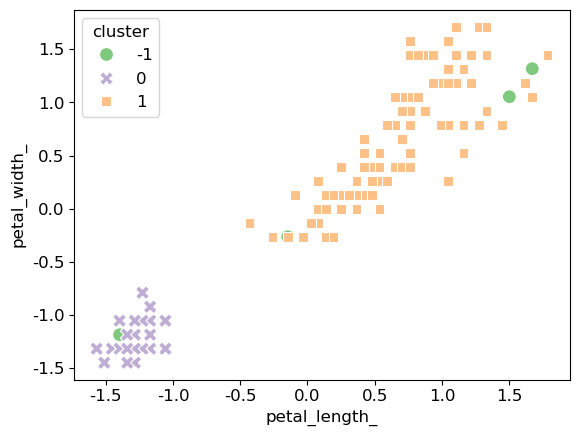

In [20]:
# 군집 결과 시각화
df['cluster'] = DB_result
fig, ax = plt.subplots(1,1)
sns.scatterplot(x='petal_length_', y='petal_width_', data=df, hue='cluster', style='cluster', s=100, ax=ax, palette='Accent')
plt.show()

#### 혼합분포군집
- EM 알고리즘: Maximum likelihood 최대화 모델 찾는 것이 목표 (보통, 로그우도 활용)
- BIC값이 가장 적고, 시각화 및 군집 타당성 지표면에서 가장 유효한 군집 개수 선택
- 장점: 군집을 몇 개의 모수로 표현, 서로 다른 크기나 모양 군집 발견 가능  
  단점: 특정 분포를 따른다는 가정 필요 (만족여부에 따라 결과 매우 다름),   
  계산량이 높아 대용량 적용 불가, 알고리즘 복잡, 이상값에 민감하여 전처리 필요

In [21]:
# 혼합분포 군집
from pandas import DataFrame
import numpy as np
from sklearn.datasets import load_iris
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# 데이터 불러오기
load = load_iris()
X = load['data']
y = load['target']
columns = list(map(lambda x: x.replace("(cm)", "").replace(" ", "_"), load['feature_names'])) 

# 데이터 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df = DataFrame(ss.fit_transform(X), columns=columns)

적정한 분포 개수 정하기:


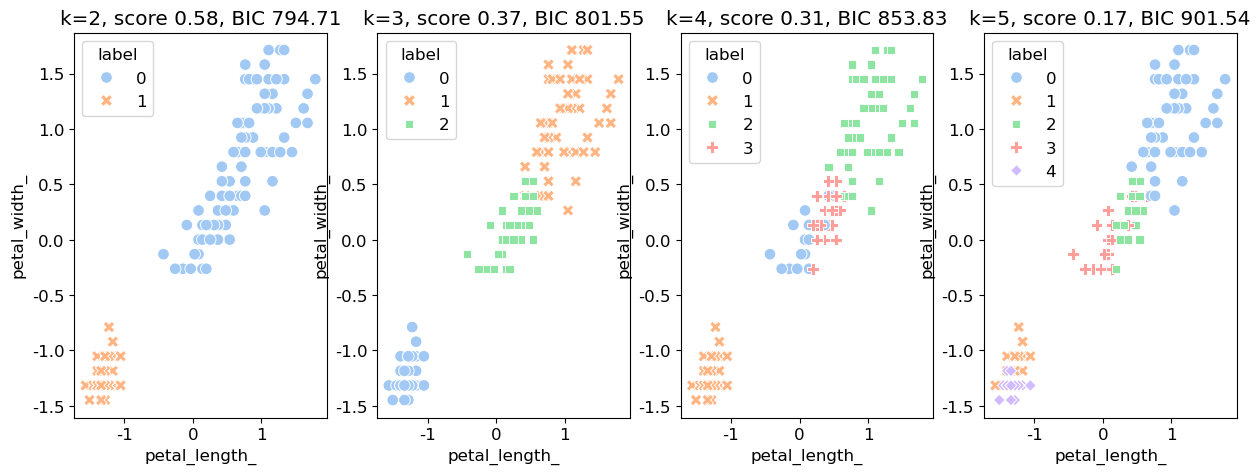

In [22]:
# 적정한 분포 개수 정하기 (=군집 개수 정하기)
print("적정한 분포 개수 정하기:")
dist_list =[2,3,4,5] # 분포 개수 후보군
fig, axes = plt.subplots(1,4, figsize = (15,5))
for ax, k in zip(axes, dist_list):
    gm = GaussianMixture(n_components=k, covariance_type='full').fit(df)
    # covariance_type: {'full', 'tied', 'diag', 'spherical'}
    temp_df = df.copy()
    temp_df['label']= gm.predict(df)
    sns.scatterplot(x='petal_length_', y='petal_width_', data=temp_df, hue='label', style='label', s=70, ax=ax, palette='pastel')
    aic, bic = gm.aic(df), gm.bic(df)
    score = silhouette_score(df, temp_df['label'])
    ax.set_title("k={}, score {:.2f}, BIC {:.2f}".format(k, score, bic))
plt.show()

In [23]:
# 확정한 k를 기반으로 각 데이터의 군집을 반환
k = 3
model = GaussianMixture(n_components=k).fit(df)
labels = model.predict(df)
GM_result = labels # 각 데이터의 군집 반환
print(GM_result)

[0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 0 0 2 2 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


In [26]:
# 군집 정보 확인
print("클러스터 구성: ", Counter(labels))
print("distribution 별 feature 평균: \n", model.means_) # {}\n {}".format(model.means_[0], model.means_[1]))
print("distribution 별 가중치: ", model.weights_)
print("모델의 로그가능도: {:.3f}".format(model.score(df)))

클러스터 구성:  Counter({1: 98, 0: 45, 2: 7})
distribution 별 feature 평균: 
 [[-0.93852253  0.98617415 -1.29410958 -1.24871335]
 [ 0.53745909 -0.39369142  0.6693573   0.64500292]
 [-1.53616188 -0.9148767  -1.05760659 -1.00758605]]
distribution 별 가중치:  [0.30201321 0.65376794 0.04421885]
모델의 로그가능도: -2.069


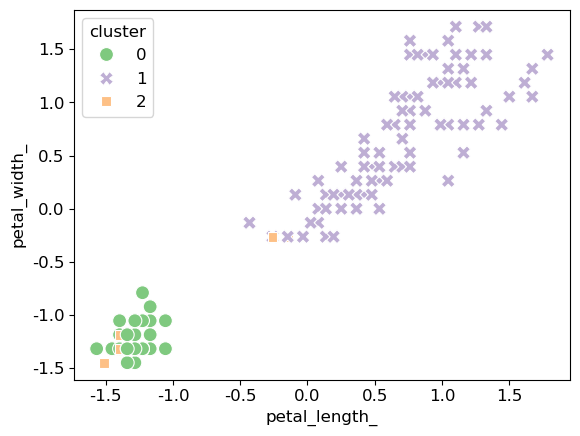

In [27]:
# 군집 결과 시각화
df['cluster'] = GM_result
fig, ax = plt.subplots(1,1)
sns.scatterplot(x='petal_length_', y='petal_width_', data=df, hue='cluster', style='cluster', s=100, ax=ax, palette='Accent')
plt.show()

#### SOM (self-organized map)
- m X n개 클러스터 생성 가능 --> 가장 적합한 네트워크 크기 = 최적 군집 개수
- 장점: 입력 데이터 사이의 위상 잘 표현, 잘 구별되지 않는 데이터간 상관관계 발견  
  단점: 거리 지표에 따라 결과 크게 다름, 수학 연산이 복잡하여 대용량 적용 X

In [29]:
!pip install sklearn_som

In [31]:
# SOM
from pandas import DataFrame
import numpy as np
from sklearn.datasets import load_iris
from sklearn_som.som import SOM

# 데이터 불러오기
load = load_iris()
X = load['data']
y = load['target']
columns = list(map(lambda x: x.replace("(cm)", "").replace(" ", "_"), load['feature_names'])) 

# 데이터 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df = DataFrame(ss.fit_transform(X), columns=columns)

적정한 네트워크의 크기 정하기:


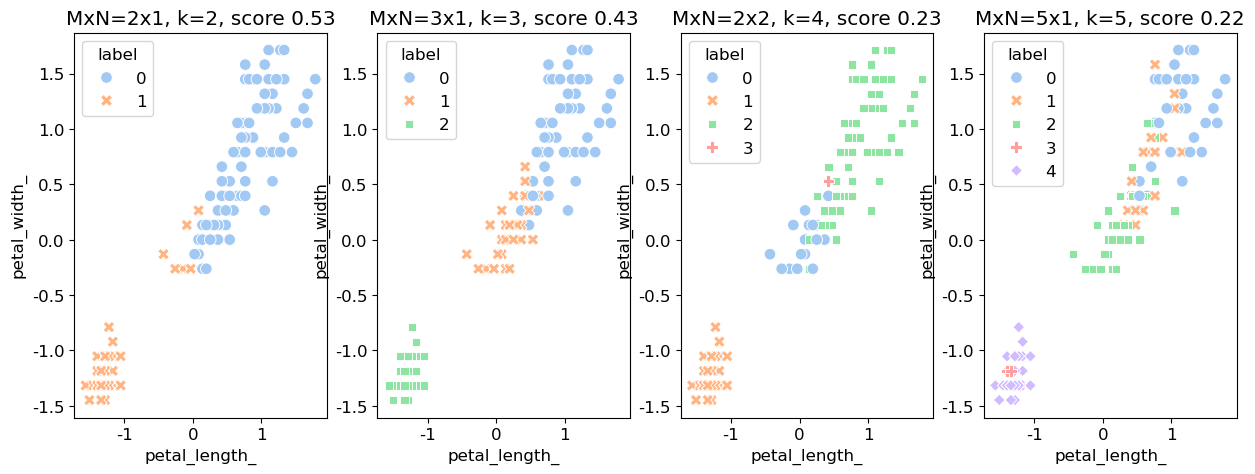

In [32]:
# 적정한 네트워크의 크기 정하기 (=군집 개수 정하기)
print("적정한 네트워크의 크기 정하기:")
mn_list =[(2,1), (3,1), (2,2), (5,1)] # 분포 개수 후보군
fig, axes = plt.subplots(1,4, figsize = (15,5))
for ax, (M, N) in zip(axes, mn_list):
    som = SOM(m=M, n=N, dim=df.shape[1]) #dim은 입력 데이터의 feature의 개수
    som.fit(df.values) #배열을 입력해야 함 (df형태는 안됨)
    labels = som.predict(df.values)
    clusterNo = len(Counter(labels))
    temp_df = df.copy()
    temp_df['label']= som.predict(df.values)
    sns.scatterplot(x='petal_length_', y='petal_width_', data=temp_df, hue='label', style='label', s=70, ax=ax, palette='pastel')
    score = silhouette_score(df, temp_df['label'])
    ax.set_title("MxN={}x{}, k={}, score {:.2f}".format(M,N,clusterNo,score))
plt.show()

In [33]:
# 확정한 k를 기반으로 각 데이터의 군집을 반환
M, N = (3, 1)
model = SOM(m=M, n=N, dim=df.shape[1])
model.fit(df.values)
labels = model.predict(df.values)
som_result = labels # 각 데이터의 군집 반환
print(som_result)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0]


In [41]:
# 군집 정보 확인
SOMmap = model.transform(df.values)
print("클러스터 구성: ", Counter(labels))
print("SOM map: \n", SOMmap[:5]) #앞 5개의 데이터 확인

클러스터 구성:  Counter({0: 56, 2: 50, 1: 44})
SOM map: 
 [[3.66460054 2.79883101 1.15947317]
 [3.60306438 2.50130424 0.83416795]
 [3.79644845 2.75780416 0.99480615]
 [3.78207687 2.70309449 0.99553977]
 [3.7980258  2.97020989 1.36544621]]


In [34]:
# 타당성 평가
from sklearn.metrics import silhouette_score, completeness_score
print("실루엣 계수: %.3f" %silhouette_score(df, labels))
print("completeness_score: %.3f" %completeness_score(y, labels))

실루엣 계수: 0.438
completeness_score: 0.714


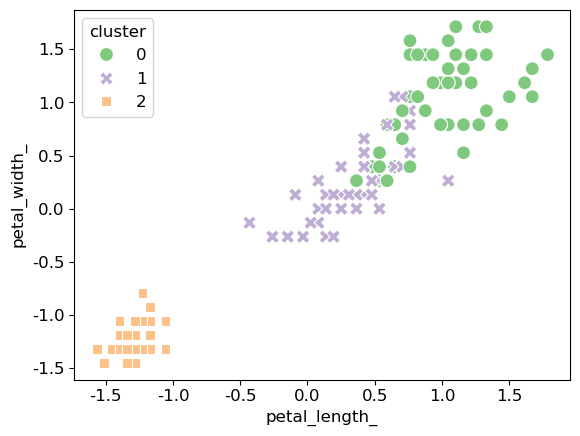

In [35]:
# 군집 결과 시각화
df['cluster'] = som_result
fig, ax = plt.subplots(1,1)
sns.scatterplot(x='petal_length_', y='petal_width_', data=df, hue='cluster', style='cluster', s=100, ax=ax, palette='Accent')
plt.show()

### **10-3. 연관규칙학습**
- 장바구니 분석, 웹 사용 마이닝, 침입 탐지, 생물 정보학 등 많은 응용 분야
- 지지도(A∩B, 0 ~ 1), 신뢰도(A∩B/A, 0 ~ 1), 향상도(A∩B/A*B, 0~inf, 1이면 독립) + 레버리지, 확신
- Apriori: 빈발항목 집합만 연관규칙 계산. 구현/이해 쉬우나 계산 복잡도 높음  
  FP-Growth: FP-Tree 분할정복 방식을 통해 빈발항목 집합 추출. DB 스캔 횟수 작고 빠른 분석 가능
- 장점: 분석 내용 쉽게 이해, 거래 내용 데이터 변환 없이 이용, 계산 간단  
  단점: 품목 수 증가시 계산 기하급수적 증가, 너무 세분화되면 의미 없음 (유사품목 묶음)  
  거래량 적은 품목 제외되기 쉬움 (유사품목에 포함)

In [37]:
# Transaction data(거래내역 데이터) 생성하기
from pandas import DataFrame
from mlxtend.preprocessing import TransactionEncoder

dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = DataFrame(te_ary, columns=te.columns_).map(lambda x: 1 if x else 0)
print(df)
## 각 거래품목에 대한 거래 여부를 표시하는 데이터로 전처리 완료

   Apple  Corn  Dill  Eggs  Ice cream  Kidney Beans  Milk  Nutmeg  Onion  \
0      0     0     0     1          0             1     1       1      1   
1      0     0     1     1          0             1     0       1      1   
2      1     0     0     1          0             1     1       0      0   
3      0     1     0     0          0             1     1       0      0   
4      0     1     0     1          1             1     0       0      1   

   Unicorn  Yogurt  
0        0       1  
1        0       1  
2        0       0  
3        1       1  
4        0       0  


In [38]:
# APRIORI 알고리즘으로 연관규칙학습

# 빈발항목집합 생성
from mlxtend.frequent_patterns import apriori
fset = apriori(df, min_support=0.6, use_colnames=True, verbose=0) 
print("빈발항목집합:\n", fset.sort_values(by='support', ascending=False))

빈발항목집합:
     support                     itemsets
1       1.0               (Kidney Beans)
0       0.8                       (Eggs)
5       0.8         (Eggs, Kidney Beans)
2       0.6                       (Milk)
3       0.6                      (Onion)
4       0.6                     (Yogurt)
6       0.6                (Onion, Eggs)
7       0.6         (Milk, Kidney Beans)
8       0.6        (Onion, Kidney Beans)
9       0.6       (Yogurt, Kidney Beans)
10      0.6  (Onion, Eggs, Kidney Beans)


C:\Users\sunwa\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [39]:
# 연관규칙 생성
from mlxtend.frequent_patterns import association_rules
# metric = {'support', 'confidence', 'lift', 'leverage', 'conviction'}
# min_threshold = metric 파라미터 값의 최솟값 설정
rule = association_rules(fset, metric="confidence", min_threshold=0.7)
rule['len_ant'] = rule['antecedents'].apply(lambda x: len(x))
rule['len_con'] = rule['consequents'].apply(lambda x: len(x))

# consequents 항목이 1이고, lift가 1.2이상인 rule만 확인
print("연관규칙:")
print(rule[(rule['len_con']==1) & (rule['lift']>=1.2)])

연관규칙:
             antecedents consequents  antecedent support  consequent support  \
2                (Onion)      (Eggs)                 0.6                 0.8   
3                 (Eggs)     (Onion)                 0.8                 0.6   
8  (Onion, Kidney Beans)      (Eggs)                 0.6                 0.8   
9   (Eggs, Kidney Beans)     (Onion)                 0.8                 0.6   

   support  confidence  lift  representativity  leverage  conviction  \
2      0.6        1.00  1.25               1.0      0.12         inf   
3      0.6        0.75  1.25               1.0      0.12         1.6   
8      0.6        1.00  1.25               1.0      0.12         inf   
9      0.6        0.75  1.25               1.0      0.12         1.6   

   zhangs_metric  jaccard  certainty  kulczynski  len_ant  len_con  
2            0.5     0.75      1.000       0.875        1        1  
3            1.0     0.75      0.375       0.875        1        1  
8            0.5     0.75

C:\Users\sunwa\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


In [40]:
# FP Growth 알고리즘으로 연관규칙학습

# 빈발항목집합 생성
from mlxtend.frequent_patterns import fpgrowth
fset = fpgrowth(df, min_support=0.6, use_colnames=True, verbose=0)
print("빈발항목집합:\n", fset.sort_values(by='support', ascending=False))

빈발항목집합:
     support                     itemsets
0       1.0               (Kidney Beans)
1       0.8                       (Eggs)
5       0.8         (Eggs, Kidney Beans)
2       0.6                     (Yogurt)
3       0.6                      (Onion)
4       0.6                       (Milk)
6       0.6       (Yogurt, Kidney Beans)
7       0.6                (Onion, Eggs)
8       0.6        (Onion, Kidney Beans)
9       0.6  (Onion, Eggs, Kidney Beans)
10      0.6         (Milk, Kidney Beans)


C:\Users\sunwa\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [41]:
# 연관규칙 생성
from mlxtend.frequent_patterns import association_rules
# metric = {'support', 'confidence', 'lift', 'leverage', 'conviction'}
# min_threshold = metric 파라미터 값의 최솟값 설정
rule = association_rules(fset, metric="confidence", min_threshold=0.7)
rule['len_ant'] = rule['antecedents'].apply(lambda x: len(x))
rule['len_con'] = rule['consequents'].apply(lambda x: len(x))

# consequents 항목이 1이고, lift가 1.2이상인 rule만 확인
print("연관규칙:")
print(rule[(rule['len_con']==1) & (rule['lift']>=1.2)])

## lift 1.25인 규칙들의 경우, Eggs를 사는 사람은 (Kidney Beans, Onion)를 살 확률이 다소 높다는 의미이다.
## leverage 0.12인 규칙들의 경우, 0에 가깝기 때문에 연관이 커 보이지 않는다.
## conviction 값들은 1 이상이기 때문에 어느 정도 C항목의 발생 여부를 예측하는데 유용하다고 볼 수 있다.

연관규칙:
             antecedents consequents  antecedent support  consequent support  \
3                (Onion)      (Eggs)                 0.6                 0.8   
4                 (Eggs)     (Onion)                 0.8                 0.6   
7  (Onion, Kidney Beans)      (Eggs)                 0.6                 0.8   
8   (Eggs, Kidney Beans)     (Onion)                 0.8                 0.6   

   support  confidence  lift  representativity  leverage  conviction  \
3      0.6        1.00  1.25               1.0      0.12         inf   
4      0.6        0.75  1.25               1.0      0.12         1.6   
7      0.6        1.00  1.25               1.0      0.12         inf   
8      0.6        0.75  1.25               1.0      0.12         1.6   

   zhangs_metric  jaccard  certainty  kulczynski  len_ant  len_con  
3            0.5     0.75      1.000       0.875        1        1  
4            1.0     0.75      0.375       0.875        1        1  
7            0.5     0.75

C:\Users\sunwa\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


#### 연습문제 #1

In [42]:
from pandas import read_csv
df = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice10_credit_card.csv')
print(df.head())

  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  PURCHASES_FREQUENCY  \
0  C10001    40.900749           0.818182      95.40             0.166667   
1  C10002  3202.467416           0.909091       0.00             0.000000   
2  C10003  2495.148862           1.000000     773.17             1.000000   
3  C10004  1666.670542           0.636364    1499.00             0.083333   
4  C10005   817.714335           1.000000      16.00             0.083333   

   PURCHASES_TRX  
0              2  
1              0  
2             12  
3              1  
4              1  


In [43]:
# 데이터 전처리: CUST_ID는 범주형 변수로서 각 고객을 식별할 뿐이기 때문에 군집 분석에서는 제외하였다. 
# 그 후, 변수 간 스케일 차이로 인한 왜곡이 일어나지 않도록 표준화를 진행하였다.
df2 = df.drop('CUST_ID', axis=1)
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled = DataFrame(ss.fit_transform(df2), columns=df2.columns)
# K-means 클러스터링과 혼합분포 군집 알고리즘으로 각각 군집을 생성하고자 한다.

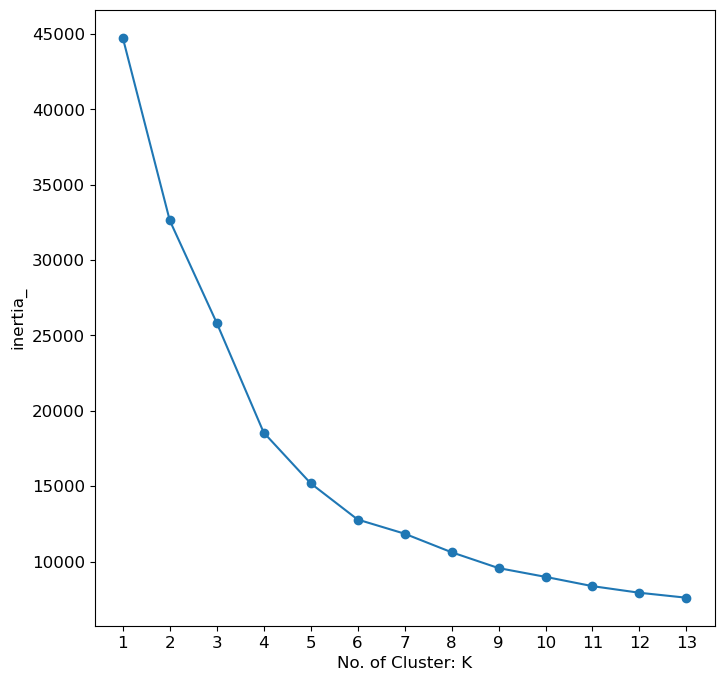

In [45]:
# K-means는 후보 군집 개수에 따른 오차제곱합들을 살펴, scree plot을 통해 elbow 방법으로 오차제곱합이 평평해지기 시작하는 지점의 군집 개수로 데이터를 군집화하고자 한다. 
from sklearn.cluster import KMeans
from collections import Counter
I = [] # 오차제곱합
for k in range(1,14):
    kmeans=KMeans(n_clusters=k).fit(scaled)
    I.append(kmeans.inertia_) # 오차제곱합
plt.plot(list(range(1,14)), I, marker="o")
plt.xticks(list(range(1,14)), list(range(1,14)))
plt.xlabel("No. of Cluster: K")
plt.ylabel("inertia_")
plt.show()
# 팔꿈치 지점으로 보이는 4를 군집의 개수로 정하기로 한다.

In [46]:
# n_cluster=4로 군집화
Kmodel = KMeans(n_clusters=4, random_state=0)
Kmodel.fit(scaled) # 해당 열 데이터의 각 cluster center와의 거리
kmeans_result = Kmodel.labels_ # 각 데이터의 군집 반환
print(Counter(kmeans_result))

# 타당성 평가
from sklearn.metrics import silhouette_score
print("실루엣 계수: %.3f" %silhouette_score(scaled, kmeans_result))

Counter({1: 3581, 3: 3477, 2: 1481, 0: 411})
실루엣 계수: 0.422


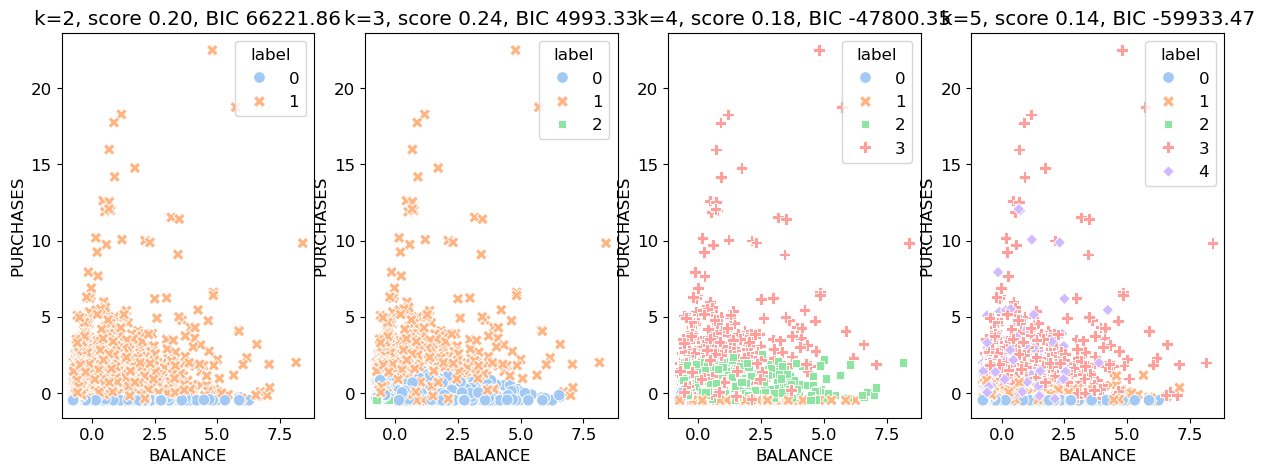

In [48]:
# 혼합분포군집 방법으로는 분포 개수 후보군으로 적합한 각각의 결과를 실루엣 계수와 BIC로 비교하고 가장 타당한 분포 개수를 정하고자 한다.
from sklearn.mixture import GaussianMixture
dist_list =[2,3,4,5]
fig, axes = plt.subplots(1,4, figsize = (15,5))
for ax, k in zip(axes, dist_list):
    gm = GaussianMixture(n_components=k, covariance_type='full').fit(scaled)
    temp_df = scaled.copy()
    temp_df['label']= gm.predict(scaled)
    sns.scatterplot(x='BALANCE', y='PURCHASES', data=temp_df, hue='label', style='label', s=70, ax=ax, palette='pastel')
    aic, bic = gm.aic(scaled), gm.bic(scaled)
    score = silhouette_score(scaled, temp_df['label'])
    ax.set_title("k={}, score {:.2f}, BIC {:.2f}".format(k, score, bic))
plt.show()
# 비교적 실루엣 스코어가 높고, BIC가 낮은 것으로 보이는 분포 개수 4개로 정하기로 한다.

In [49]:
# n_components=4로 군집화
Gmodel = GaussianMixture(n_components=4)
Gmodel.fit(scaled)
GM_result = Gmodel.predict(scaled)
print(Counter(GM_result))

# 타당성 평가
from sklearn.metrics import silhouette_score
print("실루엣 계수: %.3f" %silhouette_score(scaled, GM_result))

Counter({1: 3410, 2: 2801, 3: 1538, 0: 1201})
실루엣 계수: 0.147


#### 연습문제 #2

In [ ]:
# 두 분포 모두 각 군집 별 데이터의 개수는 고르게 배치된 것으로 보이지만, 
# 실루엣 계수로 미루어볼 때 군집 내의 응집도와 군집 간 분리도가 더 높은 K-means(0.422)의 결과가 
# 혼합분포군집(0.175)의 결과보다 더 타당한 것으로 보인다. 이에 K-means 모델을 선택하고자 한다.

#### 연습문제 #3

In [54]:
df['cluster'] = kmeans_result
print(df[df['cluster']==0].describe().round(2).iloc[:, :-1])
# 군집0은 3478개의 고객이 해당되는 군집으로서 구매계좌 잔액 평균 2397에, 
# 계좌 업데이트 빈도지수 평균이 0.98이며, 구매액 평균이 230.47이고, 
# 구매 빈도지수 평균은 0.13이고, 거래 건수 평균은 2.38의 특성을 보인다.
# 해당 군집은 구매계좌 잔액과 계좌 업데이트 빈도지수는 높은 편이지만, 
# 실제 구매는 많이 이루어지지 않는 군집이다. '잠재 구매력 고객'으로 정의할 수 있다.

        BALANCE  BALANCE_FREQUENCY  PURCHASES  PURCHASES_FREQUENCY  \
count    411.00             411.00     411.00               411.00   
mean    3949.42               0.99    7357.12                 0.96   
std     3413.78               0.05    6147.04                 0.12   
min      137.64               0.27     885.44                 0.17   
25%     1161.21               1.00    4010.72                 1.00   
50%     2971.60               1.00    5671.86                 1.00   
75%     5749.25               1.00    8482.49                 1.00   
max    19043.14               1.00   49039.57                 1.00   

       PURCHASES_TRX  
count         411.00  
mean           95.29  
std            53.43  
min             3.00  
25%            64.50  
50%            84.00  
75%           111.00  
max           358.00  


In [55]:
print(df[df['cluster']==1].describe().round(2).iloc[:, :-1])
# 군집1는 3604개의 고객이 해당되는 군집으로서 구매계좌 잔액 평균 1084.17에, 
# 계좌 업데이트 빈도지수 평균이 0.97이며, 구매액 평균이 1316.54이고, 
# 구매 빈도지수 평균은 0.87이고, 거래 건수 평균은 21.97의 특성을 보인다.
# 전체 고객의 40%가 군집 2에 해당할 만큼 일반적인 군집 특성을 가진다. 
# 구매계좌 잔액과 구매액은 일반적이지만 계좌 업데이트 빈도는 매우 높고, 
# 구매 빈도지수도 높은 편이며, 거래 건수도 높은 편에 속한다. "높은 구매력 고객"으로 정의할 수 있다.

       BALANCE  BALANCE_FREQUENCY  PURCHASES  PURCHASES_FREQUENCY  \
count  3581.00            3581.00    3581.00              3581.00   
mean   1061.86               0.97    1293.55                 0.87   
std    1407.63               0.08    1132.99                 0.16   
min       0.73               0.45       8.40                 0.25   
25%     109.79               1.00     461.36                 0.75   
50%     472.69               1.00     924.60                 0.92   
75%    1452.22               1.00    1819.00                 1.00   
max    9598.38               1.00    8591.31                 1.00   

       PURCHASES_TRX  
count        3581.00  
mean           21.68  
std            14.37  
min             0.00  
25%            12.00  
50%            17.00  
75%            28.00  
max            98.00  


In [56]:
print(df[df['cluster']==2].describe().round(2).iloc[:, :-1])
# 군집2은 1485개의 고객이 해당되는 군집으로서 구매계좌 잔액 평균 155.46에, 
# 계좌 업데이트 빈도지수 평균이 0.40이며, 구매액 평균이 353.70이고, 
# 구매 빈도지수 평균은 0.28이고, 거래 건수 평균은 4.45의 특성을 보인다.
# 해당 군집은 구매계좌 잔액과 계좌 업데이트 빈도가 낮고, 구매액과 구매빈도도 낮은 '낮은 구매력 고객'으로 정의할 수 있다.

       BALANCE  BALANCE_FREQUENCY  PURCHASES  PURCHASES_FREQUENCY  \
count  1481.00            1481.00    1481.00              1481.00   
mean    155.13               0.40     351.92                 0.28   
std     333.87               0.20     527.46                 0.27   
min       0.00               0.00       0.00                 0.00   
25%       7.57               0.27      32.22                 0.08   
50%      29.36               0.44     160.80                 0.18   
75%     131.26               0.55     438.87                 0.42   
max    3947.75               0.75    5252.04                 1.00   

       PURCHASES_TRX  
count        1481.00  
mean            4.42  
std             5.20  
min             0.00  
25%             1.00  
50%             3.00  
75%             6.00  
max            41.00  


In [57]:
print(df[df['cluster']==3].describe().round(2).iloc[:, :-1])
# 군집3은 3478개의 고객이 해당되는 군집으로서 구매계좌 잔액 평균 2397에, 
# 계좌 업데이트 빈도지수 평균이 0.98이며, 구매액 평균이 230.47이고, 
# 구매 빈도지수 평균은 0.13이고, 거래 건수 평균은 2.38의 특성을 보인다.
# 해당 군집은 구매계좌 잔액과 계좌 업데이트 빈도지수는 높은 편이지만, 
# 실제 구매는 많이 이루어지지 않는 군집이다. '잠재 구매력 고객'으로 정의할 수 있다.

        BALANCE  BALANCE_FREQUENCY  PURCHASES  PURCHASES_FREQUENCY  \
count   3477.00            3477.00    3477.00              3477.00   
mean    2400.50               0.98     230.52                 0.13   
std     2283.38               0.06     466.19                 0.18   
min        0.49               0.55       0.00                 0.00   
25%      926.34               1.00       0.00                 0.00   
50%     1603.99               1.00       0.05                 0.08   
75%     3106.42               1.00     255.34                 0.25   
max    16304.89               1.00    4900.00                 1.00   

       PURCHASES_TRX  
count        3477.00  
mean            2.38  
std             3.86  
min             0.00  
25%             0.00  
50%             1.00  
75%             4.00  
max            34.00  


findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding'

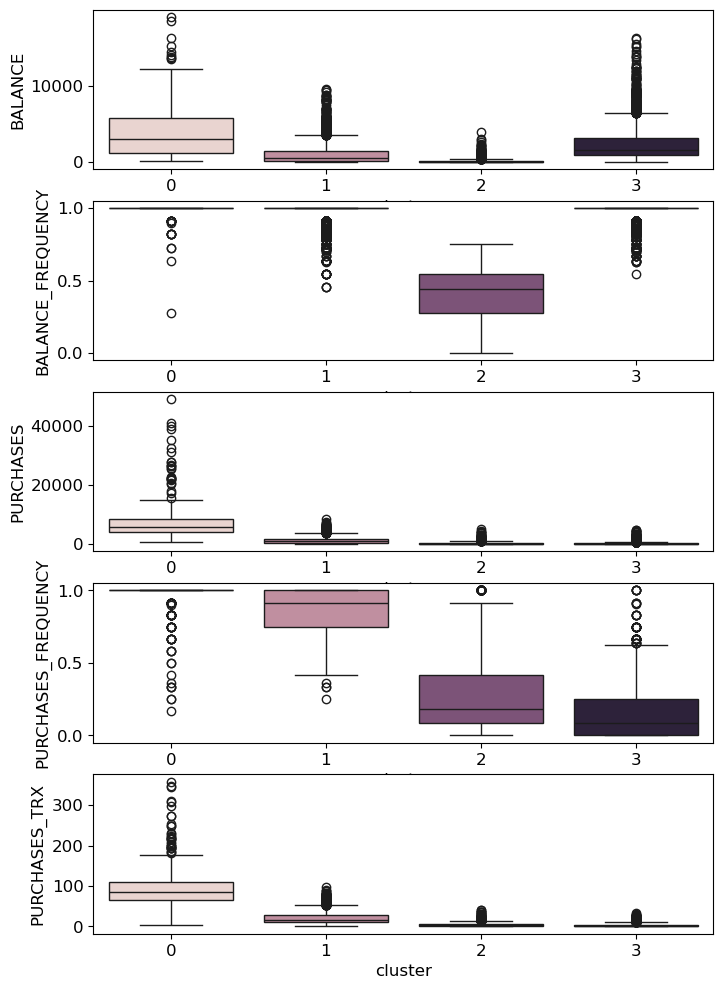

In [59]:
# 특성 별 각 군집의 데이터 분포는 아래와 같이 시각화 할 수 있다.
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (8,12)
fig, axes = plt.subplots(5,1)
for ax, col in zip(axes, ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'PURCHASES_FREQUENCY', 'PURCHASES_TRX']):
    sns.boxplot(x='cluster', y=col, hue='cluster', data=df, ax=ax)
    ax.legend().remove()
plt.show()

#### 연습문제 #4

In [62]:
# 주어진 데이터를 앞서 표준화한 기준으로 정규화하고, 적합한 군집 모델로 예측한 결과 군집 0이 나왔다.
Kmodel.predict(ss.transform([[3000, 1, 6000, 1, 100]]))

C:\Users\sunwa\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\sunwa\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


array([0])

#### 연습문제 #5

In [63]:
# 여러 군집들 중에서도 군집 3을 메인 타겟으로 한 마케팅 전략을 제안한다. 
# 군집 3에 해당하는 고객들은 전체의 39%를 차지하여 규모가 클 뿐만 아니라, 
# 구매계좌 잔액, 계좌 업데이트 빈도 지수를 미루어보아 구매력이 높은 집단으로 판단되기 때문이다. 
# 다만, 현재 해당 군집의 구매액, 구매 빈도, 거래 건수가 낮은 이유는 해당 군집들이 필요로하는 
# 제품의 라인업이 부족하거나 구매 과정 상의 동선, 프로모션 부족 등의 문제가 있을 것으로 예상한다. 
# 이러한 문제점을 파악하여 제품 라인업을 보충하고, 구매 과정 상의 동선을 확인하거나 해당 군집을 대상으로 한 프로모션을 기획하기를 제안한다.